In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pystarboard.data_spacescope as dss
from datetime import date, timedelta, datetime
import pandas as pd
import numpy as np
import numpy.random

import gas_models
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.interpolate import interp1d

from sklearn.neighbors import KernelDensity
import pyvinecopulib as pv

In [3]:
# for modeling base-fee to total-gas-usage, we can use more data for training than learning the PSD
# gas usage b/c we want to create a general mapping between basefee and total-gas-usage, regardless
# of message type
training_start_date = date(2021, 3, 15)
training_end_date = date.today()-timedelta(days=3)
df_basefee = gas_models.get_basefee_spacescope(training_start_date, training_end_date)
df_basefee_daily = df_basefee.groupby(df_basefee['hour_date'].dt.date).mean()
gas_train_df = gas_models.get_daily_gasusage_training_data(training_start_date, training_end_date)

(array([796.,  73.,  17.,   8.,  14.,   9.,   5.,   3.,   3.,   1.]),
 array([1.01729149e-07, 4.88233192e-01, 9.76466283e-01, 1.46469937e+00,
        1.95293246e+00, 2.44116555e+00, 2.92939864e+00, 3.41763173e+00,
        3.90586483e+00, 4.39409792e+00, 4.88233101e+00]),
 <BarContainer object of 10 artists>)

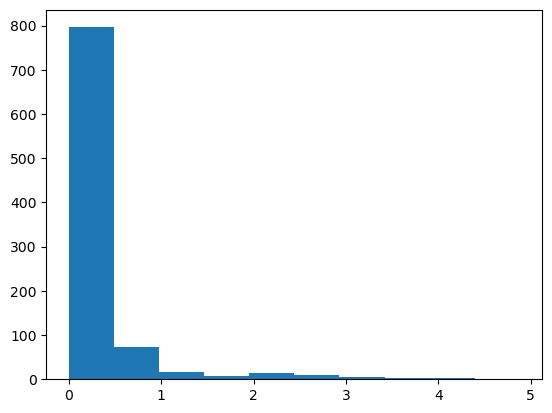

In [4]:
plt.figure()
plt.hist(df_basefee_daily['unit_base_fee'].values)

In [5]:
train_df = pd.DataFrame()
train_df['daily_base_fee'] = df_basefee_daily['unit_base_fee'].values
train_df['total_gas_used'] = gas_train_df['total_gas_used'].values

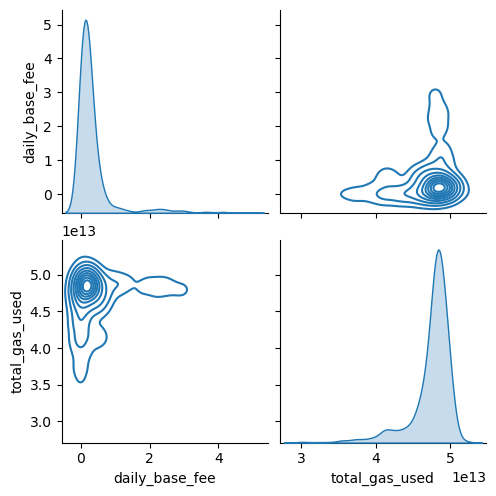

In [6]:
sns.pairplot(train_df, kind='kde')

In [7]:
df_basefee_lily = gas_models.get_message_gas_economy_lily(HEIGHT=3_000_000)
df_basefee_lily=df_basefee_lily.sort_values(by='height')
df_basefee_lily=df_basefee_lily.set_index('height')
firstBlock=df_basefee_lily.index[0]
lastBlock=df_basefee_lily.index[-1]

In [8]:
basefee_totalgas_tsmodel = gas_models.AvgBaseFeeTotalGasUsageARMAModel(df_basefee_lily)
basefee_totalgas_tsmodel.fit()

/opt/anaconda3/envs/mechafil_jax/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/mechafil_jax/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/mechafil_jax/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               base_fee   No. Observations:               240210
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -113747.334
Date:                Mon, 02 Oct 2023   AIC                         227500.668
Time:                        08:08:02   BIC                         227531.836
Sample:                             0   HQIC                        227509.769
                             - 240210                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0102      0.001    -10.416      0.000      -0.012      -0.008
ar.L1          0.1131      0.002     56.050      0.000       0.109       0.117
sigma2         0.1509      0.001    301.123      0.0

In [9]:
blocks_per_day = 2880*5.0
gstar = 5e9
    
def gt2gtilde(gt_day):
    gt_block = gt_day / blocks_per_day
    gtilde = (gt_block-gstar)/gstar
    return gtilde

In [31]:
# find mapping between gtilde and gas_used from simulation
gt_lo=5000e9
gt_hi=150000e9
resolution=20
basefee_totalgas_tsmodel.map_gtilde2gt(gt_lo=gt_lo, gt_hi=gt_hi, resolution=resolution)

  0%|          | 0/20 [00:00<?, ?it/s]

Text(0, 0.5, '$\\tilde{G}$')

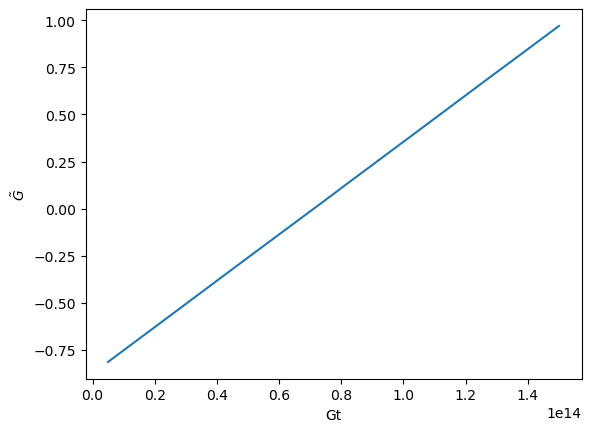

In [32]:
# plot the mappings
gt_vec = np.linspace(gt_lo, gt_hi, resolution)
plt.plot(gt_vec, basefee_totalgas_tsmodel.inverse_fn(gt_vec))
plt.xlabel('Gt')
plt.ylabel(r'$\tilde{G}$')

In [33]:
# sample from ar process w/ an offset to show that the histogram is centered
desired_gt = 50000e9
gtilde_offset_vec = [basefee_totalgas_tsmodel.inverse_fn(desired_gt)]

test_basefee, test_gtilde = basefee_totalgas_tsmodel.sample_basefee(
    ndays_per_realization=1, 
    nsamps_per_offset=120, 
    gtilde_offset_vec=gtilde_offset_vec,
    same_basefee_within_epoch=True
)

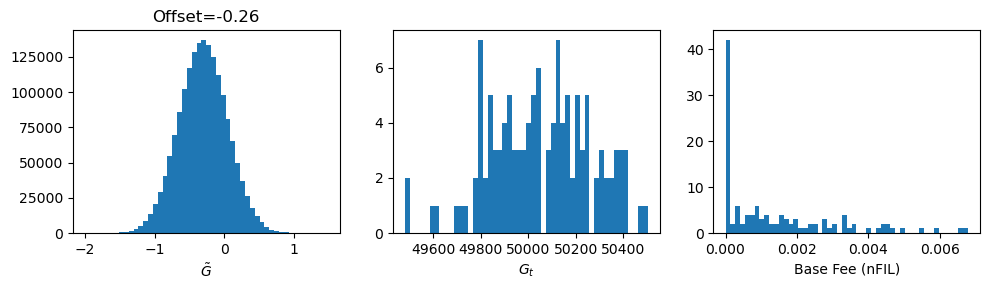

In [34]:
plt.figure(figsize=(10,3))

plt.subplot(131)
plt.hist(test_gtilde, bins=50)
plt.xlabel(r'$\tilde{G}$')
plt.title('Offset=%0.02f' % (basefee_totalgas_tsmodel.inverse_fn(desired_gt), ))

plt.subplot(132)
gt = test_gtilde*gstar + gstar
# aggregate to sum/day
gt_day_sum = gt.reshape(-1,int(blocks_per_day)).T.sum(axis=0)
plt.hist(gt_day_sum*1e-9, bins=50)
plt.xlabel(r'$G_t$')

plt.subplot(133)
basefee_avg_day = test_basefee.reshape(-1,int(blocks_per_day)).T.mean(axis=0)
plt.hist(basefee_avg_day*1e9, bins=50)
plt.xlabel('Base Fee (nFIL)')

plt.tight_layout()

In [18]:
# now, resimulate w/ the correct gtilde vecs
desired_gas_vec = np.linspace(10000, 30000, 25)*1e9

# simulate the data for the different total gas usage
basefee_avg_day, totalgas_day = basefee_totalgas_tsmodel.sample_basefee_avgdaily_totalgas_sumdaily(
    ndays_per_realization=1, 
    nsamps_per_offset=len(train_df)//len(gtilde_offset_vec), 
    gt_total_vec=desired_gas_vec,
    same_basefee_within_epoch=True
)
# put this into a dataframe
basefee_totalgas_synthetic_df = pd.DataFrame()
basefee_totalgas_synthetic_df['daily_base_fee'] = basefee_avg_day*1e9  # convert to units of nanofil
basefee_totalgas_synthetic_df['total_gas_used'] = totalgas_day

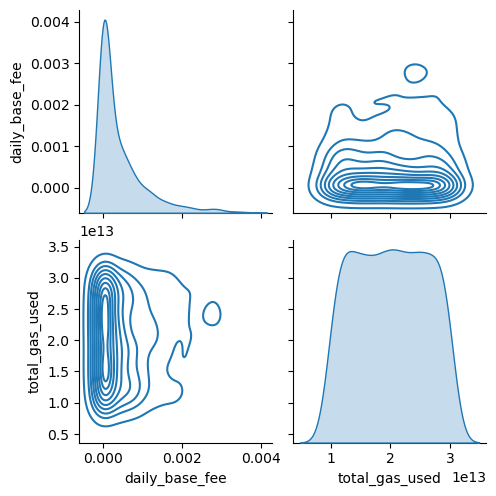

In [19]:
sns.pairplot(basefee_totalgas_synthetic_df, kind='kde')

In [20]:
train_df_full = pd.concat([train_df, basefee_totalgas_synthetic_df], ignore_index=True)

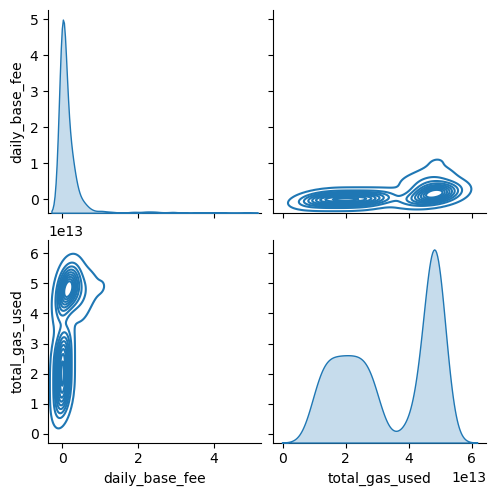

In [21]:
sns.pairplot(train_df_full, kind='kde')

In [37]:
num_mc = 10
ndays=1
gtilde_offset = basefee_totalgas_tsmodel.inverse_fn(100000*1e9)
basefee_0_5, gtilde_0_5 = basefee_totalgas_tsmodel.sample_basefee(
    ndays_per_realization=ndays,
    nsamps_per_offset=num_mc,
    gtilde_offset_vec=[gtilde_offset],
    same_basefee_within_epoch=True,
    starting_basefee=0.5
)

basefee_5, gtilde_5 = basefee_totalgas_tsmodel.sample_basefee(
    ndays_per_realization=ndays,
    nsamps_per_offset=num_mc,
    gtilde_offset_vec=[gtilde_offset],
    same_basefee_within_epoch=True,
    starting_basefee=5
)

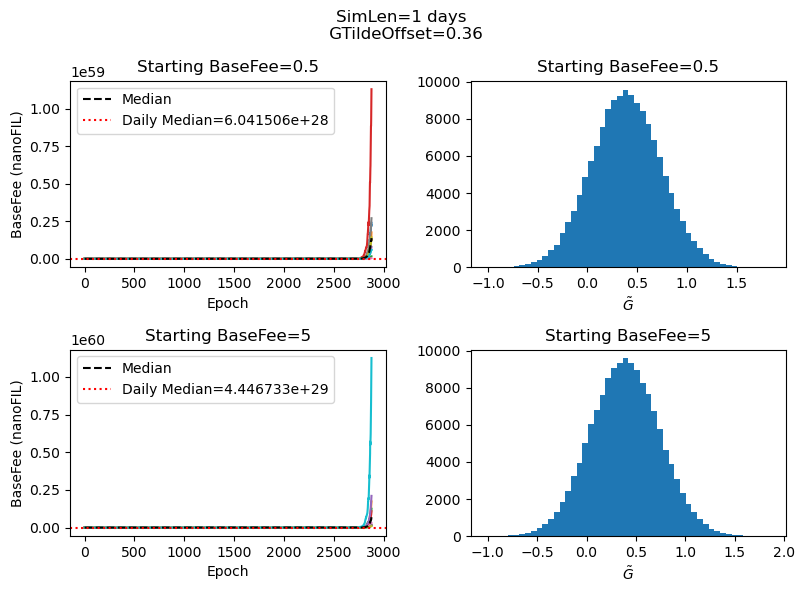

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6))

axx = ax[0,0]
basefee_reshaped = np.reshape(basefee_0_5, (num_mc,-1))
for ii in range(num_mc):
    axx.plot(basefee_reshaped[ii,::5])
median_ts = np.median(basefee_reshaped,axis=0)[::5]
axx.plot(median_ts,color='k', linestyle='--', label='Median')
axx.axhline(np.median(median_ts), color='r', linestyle=':', label='Daily Median=%e' % (np.median(median_ts),))
axx.legend()
axx.set_title('Starting BaseFee=0.5')
axx.set_xlabel('Epoch')
axx.set_ylabel('BaseFee (nanoFIL)')

axx = ax[0,1]
axx.hist(gtilde_0_5,bins=50)
axx.set_title('Starting BaseFee=0.5')
axx.set_xlabel(r'$\tilde{G}$')

axx = ax[1,0]
basefee_reshaped = np.reshape(basefee_5, (num_mc,-1))
for ii in range(num_mc):
    axx.plot(basefee_reshaped[ii,::5])
median_ts = np.median(basefee_reshaped,axis=0)[::5]
axx.plot(median_ts,color='k', linestyle='--', label='Median')
axx.axhline(np.median(median_ts), color='r', linestyle=':', label='Daily Median=%e' % (np.median(median_ts),))
axx.legend()
axx.set_title('Starting BaseFee=5')
axx.set_xlabel('Epoch')
axx.set_ylabel('BaseFee (nanoFIL)')

axx = ax[1,1]
axx.hist(gtilde_5,bins=50)
axx.set_title('Starting BaseFee=5')
axx.set_xlabel(r'$\tilde{G}$')

plt.suptitle('SimLen=%d days \n GTildeOffset=%0.02f' % (ndays,gtilde_offset))
plt.tight_layout()